In [259]:
import TTO
import numpy as np
import emailnotify
import nlopt
'''
    Simple example of cube-like domain with 8 nodes in the corners - four of which are bound and one is loaded by single force. 
    Run with the following uncommented at the end of this file:
        example.default_setup()
        example.plot('bcs')
        example.opt()
        example.plot('res')

'''
x0 = 100  # length of domain in x direction [mm]
y0 = 100  # length of domain in y direction [mm]
z0 = 0  # length of domain in z direction [mm]
nx = 21  # number of nodes in x direction [-]
ny = 9  # number of nodes in y direction [-]
nz = 2  # number of nodes in z direction [-]
E = 2.1e5  # Young's modulus E[MPa]
r0 = 10  # initial guess for bar radii [mm]
rmin = 1e-5
ratio = 0.5  # ratio between final volume of material and initial V/V0 [-]
# Initial volume from which we optimize to the desired ratio [mm^3]
Vol0 = x0*y0*z0
# Density of the material (would be used in dynamic analysis, which is not default)
Ro = 1
# convergence of 1 % is set to end the optimization loop (when only one percentage is being made, the loop exits)
kon = 1
A0 = np.pi*r0**2
Amin = np.pi*rmin**2


In [260]:
# bcs = np.array([[0, 1, 1], [1, 1, 1]])  # 4 boundary conditions
# f = np.array([[2, 0, -1000]])  # one force

In [261]:
# nx = 7 ny = 5
# bcs = np.array([[0, 1, 1], [4, 1, 1]])
# f = np.array([[32, 0, -1000]])

In [262]:
# nx = 21 ny = 9
bcs = np.array([[0, 1, 1], [8, 1, 1]])
f = np.array([[184, 0, -1000]])


In [263]:
example = TTO.Truss('example', x0, y0, z0, nx, ny, nz,
                    bcs, f, E, r0, Vol0, ratio, Ro, kon)

In [264]:
# performs default setup of a problem - this means running:
example.default_setup()
example.rem_long_bars(3)  # so that the optimization doesn't take too long
# example.plot('bcs') # plotting boundary conditions and forces
Vol0 = np.sum(example.len)*A0
Vol = ratio*Vol0
A = ratio*A0

In [265]:
def myfunc(x, grad):
    example.matK2(x)
    example.forces()
    example.boundary(example.K2)
    example.zerocrosssection(example.K2)
    u = np.linalg.inv(example.K2) @ example.f
    n = np.empty_like(x)
    for i in range(example.num_bars):
        slc2 = example.cB * example.bars[i][2]
        slc1 = example.cB * example.bars[i][1]
        n[i] = (example.E * x[i] * float(example.vec[i] @ (u[slc2:slc2 +
                example.cB] - u[slc1:slc1 + example.cB])) / example.len[i])
    example.n = n
    if grad.size > 0:
        grad[:] = -0.25 * n[:]**2*example.len[:,0]/(E*x[:]**2)
    # print(n[:]**2*example.len[:, 0]/(E*x[:]))
    print(0.5*np.sum(n[:]**2*example.len[:, 0]/(E*x[:])))
    return 0.5*np.sum(n[:]**2*example.len[:,0]/(E*x[:]))
# def myfunc(x, grad):
#     print(x)
#     example.matK2(x)
#     example.matK3()
#     example.forces()
#     example.boundary(example.K2)
#     example.zerocrosssection(example.K2)
#     example.K3 = example.boundary(example.K3)
#     example.K3 = example.zerocrosssection(example.K3)
#     u = np.linalg.inv(example.K2) @ example.f

#     if grad.size > 0:
#         grad[:] = - u.T @ example.K3 @ u
#     return u.T @ example.K2 @ u

def myconstraint(x, grad):
    if grad.size > 0:
        grad[:] = example.len[:, 0]
    return np.inner(example.len[:, 0], x[:])-Vol


# def myconstraint2(x, grad):
#     if grad.size > 0:
#         grad[:] = example.len[:, 0]
#     return -np.inner(example.len[:, 0], x[:])+Vol


In [266]:
# opt = nlopt.opt(nlopt.LN_COBYLA, example.num_bars)
opt = nlopt.opt(nlopt.LD_MMA, example.num_bars)
opt.set_lower_bounds(np.ones(example.num_bars)*Amin)
opt.set_min_objective(myfunc)
opt.add_inequality_constraint(
    lambda x, grad: myconstraint(x, grad))
# opt.add_inequality_constraint(
#     lambda x, grad: myconstraint2(x, grad))
opt.set_xtol_rel(1e-15)
x = opt.optimize(np.ones(example.num_bars)*A)
minf = opt.last_optimum_value()
print("optimum at ", x)
print("minimum value = ", minf)
print("result code = ", opt.last_optimize_result())
example.res = np.column_stack(
    (np.sqrt(x/np.pi), example.bars))
#     # like example.res but now only saving non-zero bars
example.nonzero_res = np.empty((np.count_nonzero(example.res[:,0]),4))
example.nonzero_res[:,] = example.res[np.nonzero(example.res[:,0]),:]
print(x@example.len[:,0])

0.13866018490874932
0.13866017541866182
0.1386600805435675
0.13865871885590147
0.13863984666335186
0.13844582739247255
0.13764012034469492
0.13663227000325745
0.1353880183761211
0.13386498962719634
0.13201779934428431
0.12979976970640084
0.1271654383412847
0.1240739454042475
0.12049320687367981
0.11640460376131656
0.11180770289134834
0.10672420976240901
0.10120034215543079
0.09530672677872705
0.08913549046355375
0.08279446472636731
0.07639917803803106
0.07006389858725412
0.06389319553576914
0.05797510734426703
0.05237700062830965
0.04714409484419579
0.04230049200346438
0.037852239202268045
0.033791344197307685
0.030100004030253306
0.026755125152053763
0.023731816804082935
0.021008710537731623
0.018670127278674658
0.01674525074270588
0.015216595294284364
0.01407028437536527
0.013168048424185936
0.012360194729546775
0.011591278032681021
0.010944473348041245
0.012779846100248245
0.01156210690272453
0.01102151925095595
0.01090212621273578
0.010890190033223286
0.010840808714275105
0.0106682

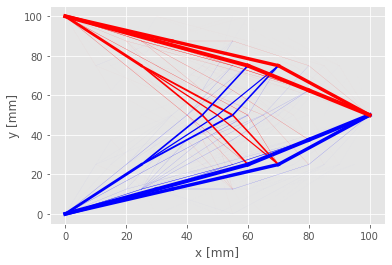

In [267]:
example.plot('res') # plotting results

In [268]:
example.num_bars

3941